## Hawaii example:
 
 3DEP data over Hawaii has heights referenced to the local mean sea level, which according to https://www.ngs.noaa.gov/GEOID/GEOID12B/computation.html is W0 from USGG2012. 
 
 Goal: reproject the data to local UTM zone in WGS84 ellipsoid CRS (for simplicity, we can say EPSG:32605+4979).



In [1]:
import xarray as xr

import cartopy.crs as ccrs
from matplotlib import colors
from matplotlib import pyplot as plt
%matplotlib inline

## Is USGG2012 same as us_noaa_g2012b ?

In [2]:
# https://cdn.proj.org
url = '/vsicurl?empty_dir=yes&url=https://cdn.proj.org/us_noaa_g2012bh0.tif'
da_2012b = xr.open_dataarray(url, engine='rasterio').squeeze()
da_2012b

<xarray.DataArray 'band_data' (y: 361, x: 421)> Size: 608kB
[151981 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 3kB 199.0 199.0 199.0 199.1 ... 206.0 206.0 206.0
  * y            (y) float64 3kB 24.0 23.98 23.97 23.95 ... 18.03 18.02 18.0
    spatial_ref  int64 8B ...
Attributes:
    TIFFTAG_IMAGEDESCRIPTION:  NAD83(PA11) (EPSG:6321) to NAVD88 height (EPSG...
    TIFFTAG_DATETIME:          2019:12:27 00:00:00
    TIFFTAG_COPYRIGHT:         Derived from work by NOAA. Public Domain
    area_of_use:               USA - Hawaii
    target_crs_epsg_code:      5703
    TYPE:                      VERTICAL_OFFSET_GEOGRAPHIC_TO_VERTICAL
    AREA_OR_POINT:             Point
    long_name:                 geoid_undulation
    units:                     metre

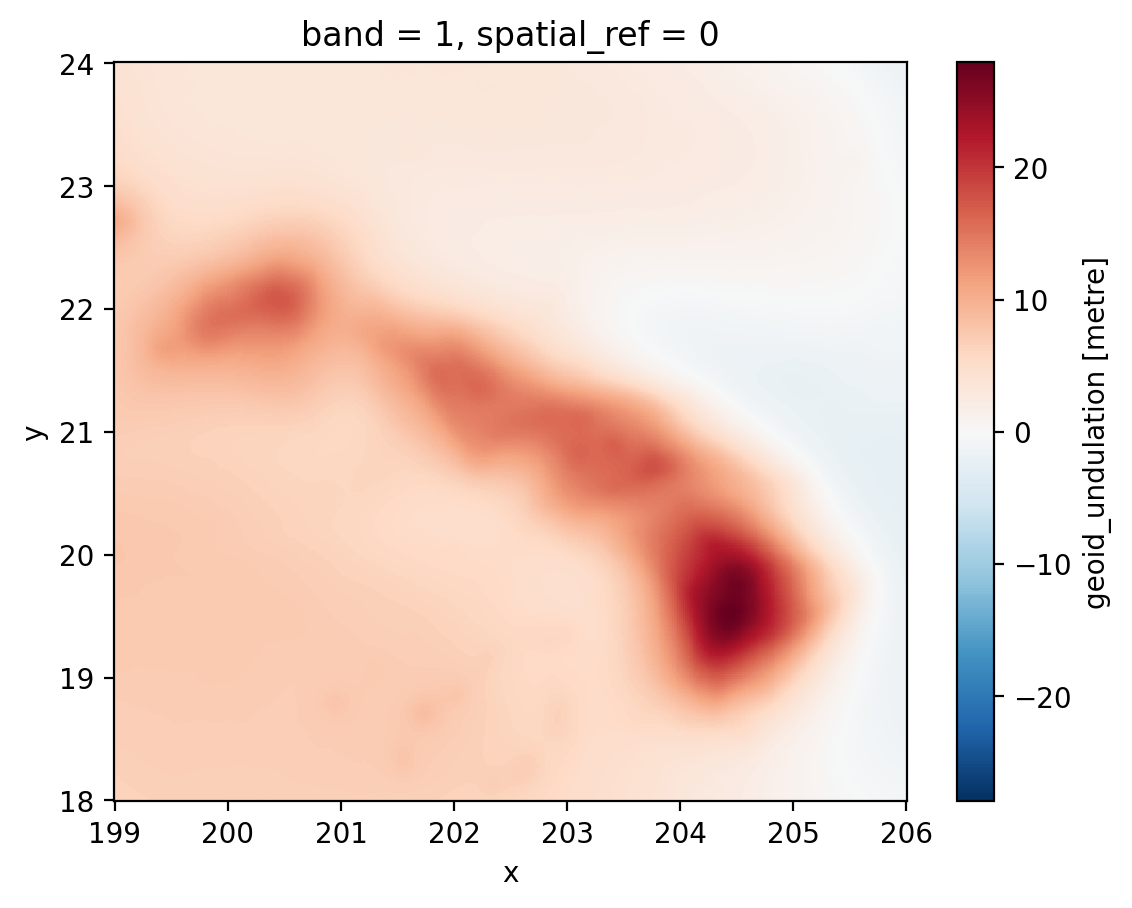

In [3]:
# NOTE x longitudes on 0-360 range
# https://stackoverflow.com/questions/53345442/about-changing-longitude-array-from-0-360-to-180-to-180-with-python-xarray
da_2012b.plot();

-2.6388 27.9582


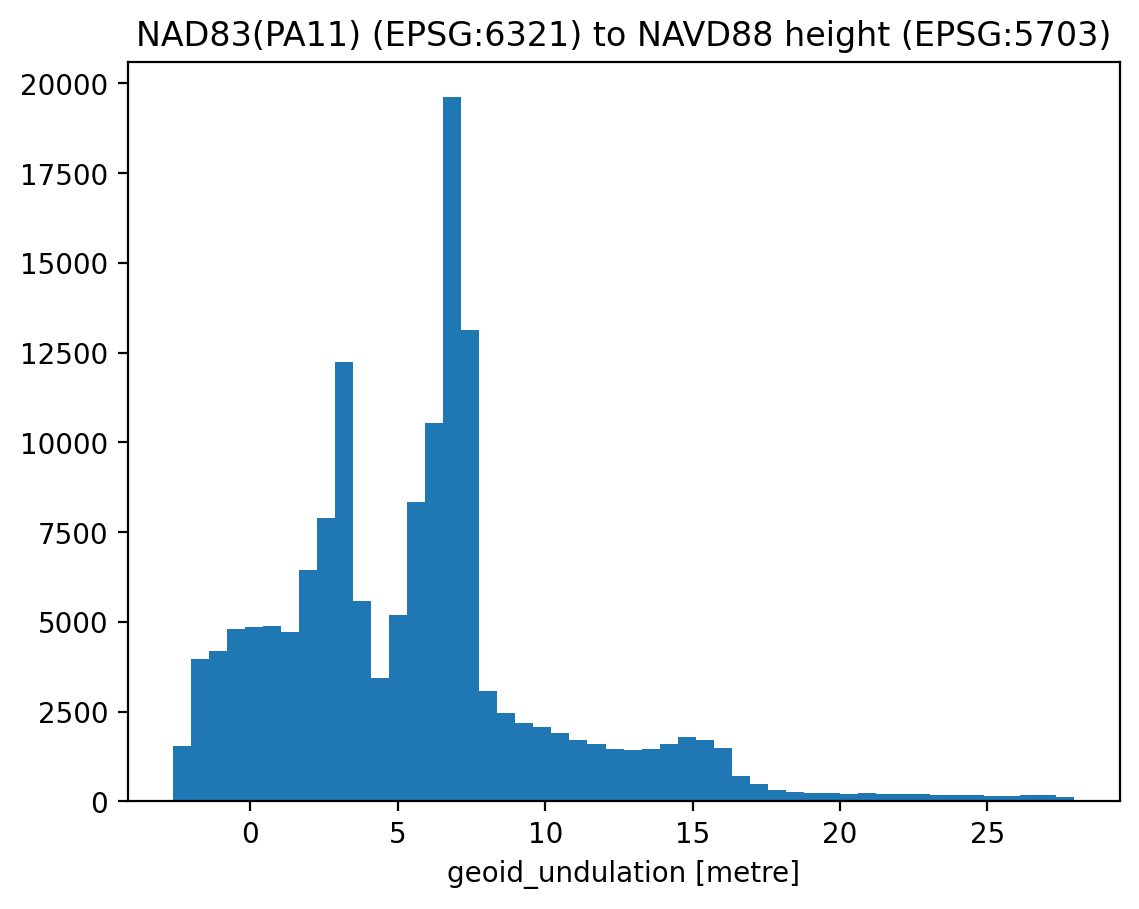

In [4]:
print(da_2012b.min().values, da_2012b.max().values)
_ = da_2012b.plot.hist(bins=50);
plt.title('NAD83(PA11) (EPSG:6321) to NAVD88 height (EPSG:5703)');

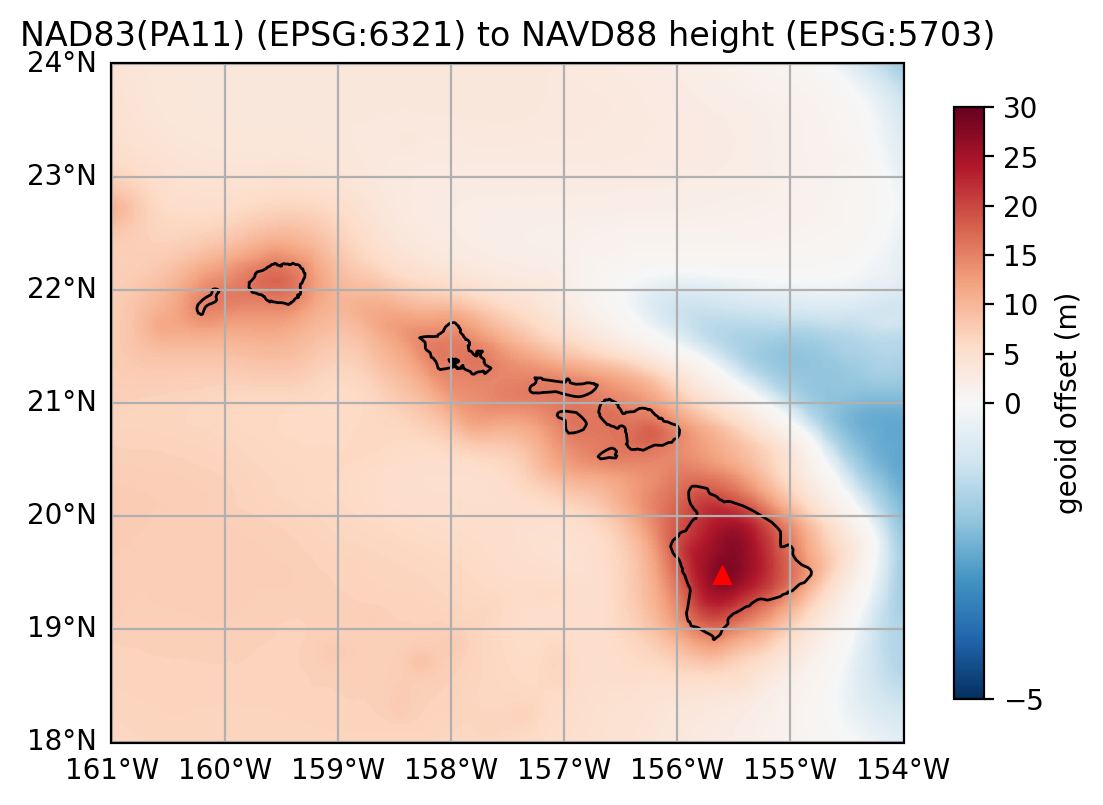

In [5]:

divnorm=colors.TwoSlopeNorm(vmin=-5, vcenter=0, vmax=30)

ax = plt.axes(projection=ccrs.PlateCarree())

da_2012b.plot.pcolormesh(ax=ax, norm=divnorm, cmap='RdBu_r',
                         cbar_kwargs=dict(shrink=0.8, label='geoid offset (m)'))

p = (-155.602829, 19.479488)
ax.plot(p[0], p[1], 'r^', transform=ccrs.PlateCarree(), label='Mauna Loa') # Mauna Loa Summit

ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#plt.legend() # crashes... probably need to do it manually...
plt.title('NAD83(PA11) (EPSG:6321) to NAVD88 height (EPSG:5703)');

NOTE: Geoid ~25-30m higher than ellipsoid for Big Island

In [6]:
da_2012b.rio.crs.to_epsg()

6321

In [7]:
print(da_2012b.rio.crs.to_proj4())

+proj=longlat +ellps=GRS80 +no_defs=True


In [8]:
# https://www.ngs.noaa.gov/GEOID/USGG2012/USGG2012_HI.shtml
# Just read the whole thing, its small
url = 'https://www.ngs.noaa.gov/PC_PROD/USGG2012/Format_pc/s2012h00.bin'
da_usgg = xr.open_dataarray(url, engine='rasterio').squeeze()
da_usgg

<xarray.DataArray 'band_data' (y: 361, x: 421)> Size: 608kB
[151981 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 3kB 199.0 199.0 199.0 199.1 ... 206.0 206.0 206.0
  * y            (y) float64 3kB 24.0 23.98 23.97 23.95 ... 18.03 18.02 18.0
    spatial_ref  int64 8B ...
Attributes:
    units:    m

In [9]:
#da_usgg.rio.crs.to_epsg()
da_usgg.rio.crs

CRS.from_wkt('GEOGCS["IGS08",DATUM["IGS08",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1141"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]')

In [10]:
# How different are these grids? just floating point rounding inconsistencies? seems so:
xr.testing.assert_equal(da_2012b.x, da_usgg.x) # equal !
#xr.testing.assert_equal(da_2012b.y, da_usgg.y) # no !
#abs(da_2012b.y.values - da_usgg.y.values).max()  np.float64(7.105427357601002e-15)
#(da_2012b.y - da_usgg.y).max()
xr.testing.assert_allclose(da_2012b.y, da_usgg.y) # yes !

In [11]:
# So just reassign coords
da_usgg = da_usgg.assign_coords(da_2012b.coords)

In [12]:
diff = da_2012b - da_usgg
diff

<xarray.DataArray 'band_data' (y: 361, x: 421)> Size: 608kB
array([[-0.41299963, -0.41239977, -0.41190004, ..., -0.1681    ,
        -0.16750002, -0.16700006],
       [-0.41289997, -0.41239977, -0.4117999 , ..., -0.16789997,
        -0.16729999, -0.16680002],
       [-0.4128003 , -0.41219997, -0.41170025, ..., -0.16779995,
        -0.16719997, -0.16659999],
       ...,
       [-0.36330032, -0.3627    , -0.36209965, ..., -0.10769999,
        -0.10700002, -0.1063    ],
       [-0.36309958, -0.3624997 , -0.36189985, ..., -0.10750002,
        -0.10689998, -0.10609999],
       [-0.36299992, -0.36240005, -0.36179972, ..., -0.10730001,
        -0.10660002, -0.10600001]], shape=(361, 421), dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 3kB 199.0 199.0 199.0 199.1 ... 206.0 206.0 206.0
  * y            (y) float64 3kB 24.0 23.98 23.97 23.95 ... 18.03 18.02 18.0
    spatial_ref  int64 8B 0

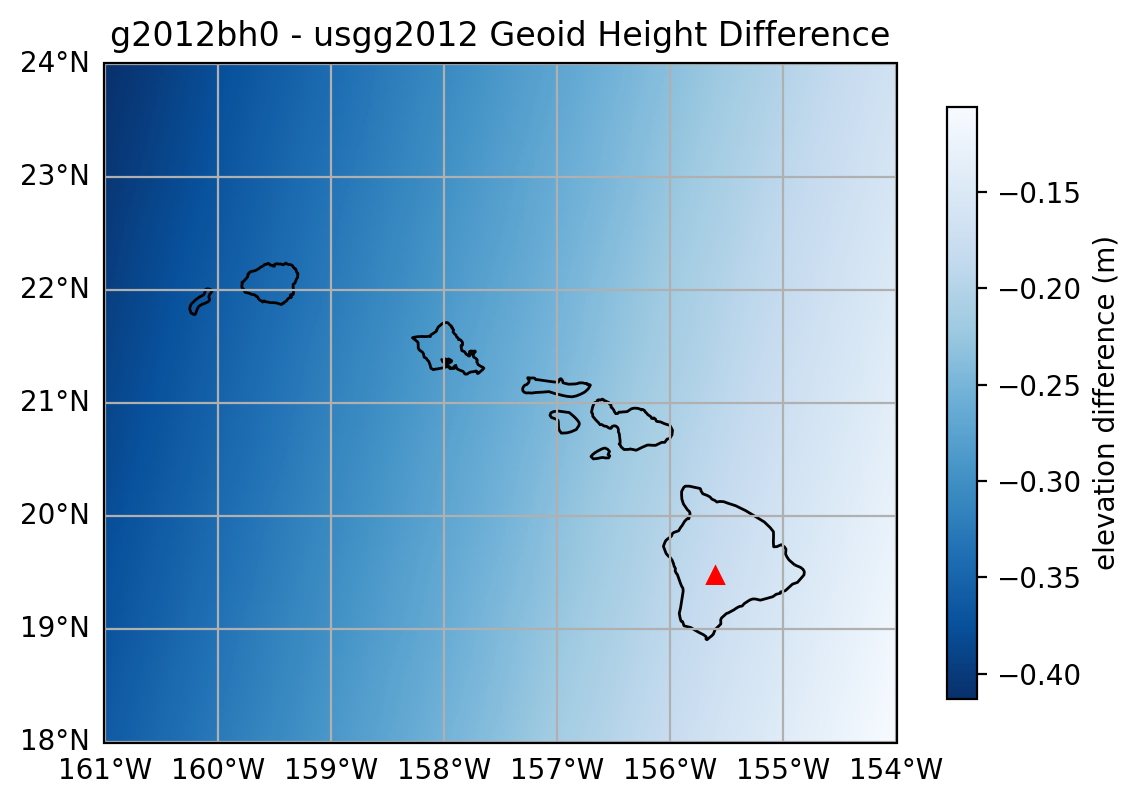

In [13]:
ax = plt.axes(projection=ccrs.PlateCarree())

diff.plot(ax=ax, cmap='Blues_r', cbar_kwargs=dict(shrink=0.8, label='elevation difference (m)')) #NOTE: not sure why diff.plot.imshow() doesn't work here...

p = (-155.602829, 19.479488)
ax.plot(p[0], p[1], 'r^', transform=ccrs.PlateCarree()) # Mauna Loa Summit

ax.coastlines()

gl = ax.gridlines(draw_labels=True) # NOTE: not sure why everywhere...
gl.top_labels = False
gl.right_labels = False

plt.title('g2012bh0 - usgg2012 Geoid Height Difference');

In [14]:
# What is the different at Mauna Loa Summit?
# GOTCHA: make sure longitude is in the range of the data (0-360 vs -180 to 180)!
#print(diff.sel(x=p[0], y=p[1], method='nearest').data)
print(diff.sel(x=360+p[0], y=p[1], method='nearest').data)

# And absolute diff?
print(da_usgg.sel(x=360+p[0], y=p[1], method='nearest').data)

-0.1794014
27.9101


### Takeaway

- GEOID is 27.9 m higher than ellipsoid at Mauna Loa summit
- USGG2012 is NOT the same as 2012B (different by 0.12 m at summit)
    - this could be important for detailed elevation studies, but for relative differences in small subregions might not matter.

## PROJ pipelines 

So if data is referenced to geoid, and we want in relative to ellipsoid, need to apply the vshift grid (then potentially also shift to other ellipsoid realizations):

In [15]:
# For global datasets it's straightforward...
!projinfo -s EPSG:4979 -t EPSG:3855 -o proj

Candidate operations found: 1
-------------------------------------
Operation No. 1:

DERIVED_FROM(EPSG):3858, WGS 84 to EGM2008 height (1), 1.0 m, World.

PROJ string:
+proj=pipeline
  +step +proj=axisswap +order=2,1
  +step +proj=unitconvert +xy_in=deg +xy_out=rad
  +step +inv +proj=vgridshift +grids=us_nga_egm08_25.tif +multiplier=1
  +step +proj=unitconvert +xy_in=rad +xy_out=deg
  +step +proj=axisswap +order=2,1


In [16]:
# As far as I can tell this is no GRID for USGG here https://cdn.proj.org
# So let's use 2012B to find transform, and can swap out grids if needed

# Hmmm... not sure why shift grids aren't showing up...
!projinfo -s EPSG:6321 -t EPSG:5703 -o proj

Candidate operations found: 1
-------------------------------------
Operation No. 1:

unknown id, Inverse of Transformation from NAVD88 height to NAD83(PA11) (ballpark vertical transformation, without ellipsoid height to vertical height correction), unknown accuracy, World, has ballpark transformation

PROJ string:
+proj=noop


In [17]:
# GEOID -> ELLIPSOID (just swap grid out)

# +proj=pipeline
#   +step +proj=axisswap +order=2,1
#   +step +proj=unitconvert +xy_in=deg +xy_out=rad
#   +step +inv +proj=vgridshift +grids=us_noaa_g2012bh0.tif +multiplier=1
#   +step +proj=unitconvert +xy_in=rad +xy_out=deg
#   +step +proj=axisswap +order=2,1

In [18]:
# NAVD88 -> WGS84 Ellipsoid realization
!projinfo EPSG:6321

PROJ.4 string:
+proj=longlat +ellps=GRS80 +no_defs +type=crs

WKT2:2019 string:
GEOGCRS["NAD83(PA11)",
    DATUM["NAD83 (National Spatial Reference System PA11)",
        ELLIPSOID["GRS 1980",6378137,298.257222101,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,3],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["ellipsoidal height (h)",up,
            ORDER[3],
            LENGTHUNIT["metre",1]],
    USAGE[
        SCOPE["Geodesy."],
        AREA["American Samoa, Marshall Islands, United States (USA) - Hawaii, United States minor outlying islands; onshore and offshore."],
        BBOX[-17.56,157.47,31.8,-151.27]],
    ID["EPSG",6321]]


In [19]:
# no-ops for NAVD88 -> WGS84...
#!projinfo -s EPSG:6322+5703 -t EPSG:7661 --spatial-test intersects

# What about ITRF? (GR80)
!projinfo -s EPSG:6322+5703 -t EPSG:7912 --spatial-test intersects

Candidate operations found: 1
-------------------------------------
Operation No. 1:

unknown id, Conversion from NAD83(PA11) (geog2D) to NAD83(PA11) (geocentric) + Inverse of ITRF2014 to NAD83(PA11) (1) + Conversion from ITRF2014 (geocentric) to ITRF2014 (geog3D) + Transformation from NAVD88 height to ITRF2014 (ballpark vertical transformation, without ellipsoid height to vertical height correction), unknown accuracy, American Samoa, Marshall Islands, United States (USA) - Hawaii, United States minor outlying islands; onshore and offshore., has ballpark transformation

PROJ string:
+proj=pipeline
  +step +proj=axisswap +order=2,1
  +step +proj=unitconvert +xy_in=deg +xy_out=rad
  +step +proj=cart +ellps=GRS80
  +step +inv +proj=helmert +x=0.9109 +y=-2.0129 +z=-0.5863 +rx=0.022749
        +ry=0.02656 +rz=-0.025706 +s=0.00212 +dx=0.0001 +dy=0.0001 +dz=-0.0019
        +drx=-0.000384 +dry=0.001007 +drz=-0.002186 +ds=0.00011 +t_epoch=2010
        +convention=coordinate_frame
  +step +inv +

In [20]:
# Add shift grid to above pipeline?
combined = '''+proj=pipeline
  +step +proj=axisswap +order=2,1
  +step +proj=unitconvert +xy_in=deg +xy_out=rad
  +step +proj=vgridshift +grids=us_noaa_g2012bh0.tif +multiplier=1
  +step +proj=cart +ellps=GRS80
  +step +inv +proj=helmert +x=0.9109 +y=-2.0129 +z=-0.5863 +rx=0.022749
        +ry=0.02656 +rz=-0.025706 +s=0.00212 +dx=0.0001 +dy=0.0001 +dz=-0.0019
        +drx=-0.000384 +dry=0.001007 +drz=-0.002186 +ds=0.00011 +t_epoch=2010
        +convention=coordinate_frame
  +step +inv +proj=cart +ellps=GRS80
  +step +proj=unitconvert +xy_in=rad +xy_out=deg
  +step +proj=axisswap +order=2,1
  '''

### Takeaways

- not sure how to get PROJ/GDAL to automatically 'pick' vshift grid + helmert transform to specific ellipsoid
- should experiment with some different ones & compare to GPS or some other 'known' reference
- See this as guidance for passing specific pipeline gdalwarp https://uw-cryo.github.io/3D_CRS_Transformation_Resources/cop30#helmert-transform-to-more-recent-wgs-itrf-realization


In [ ]:
%%bash


# Use GDAL Warp to *encode* the appropriate PROJ pipeline
# Pass extents explicity using PROJ pipeline
# https://github.com/OSGeo/gdal/issues/11610
PROJ_PIPELINE='+proj=pipeline +step +proj=axisswap +order=2,1 +step +proj=unitconvert +xy_in=deg +xy_out=rad +step +proj=vgridshift +grids=us_nga_egm08_25.tif +multiplier=1 +step +proj=cart +ellps=WGS84 +step +proj=helmert +x=-0.0007 +y=-0.0012 +z=0.0261 +rx=0 +ry=0 +rz=0 +s=-0.00212 +dx=-0.0001 +dy=-0.0001 +dz=0.0019 +drx=0 +dry=0 +drz=0 +ds=-0.00011 +t_epoch=2010 +convention=position_vector +step +inv +proj=cart +ellps=GRS80 +step +proj=unitconvert +xy_in=rad +xy_out=deg +step +proj=axisswap +order=2,1'
echo $PROJ_PIPELINE
INPUT= ????
OUTPUT=/tmp/test.vrt

CPL_DEBUG=OFF PROJ_DEBUG=2 \
 PROJ_NETWORK=ON \
 GDAL_DISABLE_READDIR_ON_OPEN=EMPTY_DIR \
 gdalwarp -overwrite -wm 500 \
    -s_srs EPSG:6322+5703 -t_srs EPSG:7912 \
    -ct "${PROJ_PIPELINE}" \
    ${INPUT} ${OUTPUT}